# Abdul Haque & i211769 
# Umm e Hani & i211715

In [18]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import itertools
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import statsmodels.api as sm
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from prophet import Prophet
from pmdarima import auto_arima
import torch
import torch.nn as nn
import torch.optim as optim
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from sklearn.svm import SVR
import pickle
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM 
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
warnings.filterwarnings('ignore')

# Load Daily atmospheric CO2 concentrations dataset which has values in ppm

### PPM stands for "parts per million." In the context of CO2 (carbon dioxide) levels, it refers to the concentration of CO2 in the atmosphere. Specifically, it represents the number of CO2 molecules per one million air molecules.

### For example, if the concentration of CO2 in the atmosphere is 400 parts per million (ppm), it means that for every one million air molecules, 400 of them are CO2 molecules.

In [19]:
df = pd.read_csv('co2_trend_gl.csv')

# Make the date to be the index

In [20]:
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df = df.set_index('date')

In [21]:
df

,year,month,day,smoothed,trend
date,,,,,
2014-01-01,2014,1,1,397.44,396.34
2014-01-02,2014,1,2,397.47,396.35
2014-01-03,2014,1,3,397.49,396.35
2014-01-04,2014,1,4,397.51,396.36
2014-01-05,2014,1,5,397.53,396.37
...,...,...,...,...,...
2024-04-29,2024,4,29,424.36,422.11
2024-04-30,2024,4,30,424.36,422.11
2024-05-01,2024,5,1,424.37,422.12


# Check if there are any null values

In [22]:
df.isnull().sum()

year        0
month       0
day         0
smoothed    0
trend       0
dtype: int64

# Plot the smoothed column of df

<Axes: xlabel='date'>

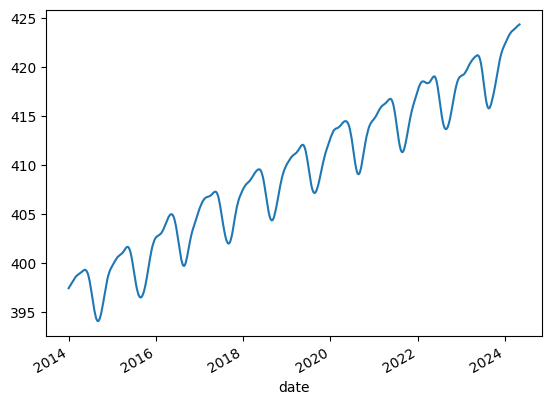

In [6]:
df['smoothed'].plot()

# Resample to get daily 

In [7]:
df_daily = df.resample('D').mean()

# Fill in values by interpolate

In [8]:
df_daily.interpolate(method='time', inplace=True)

# Lets check if any seasonal patterns are available 

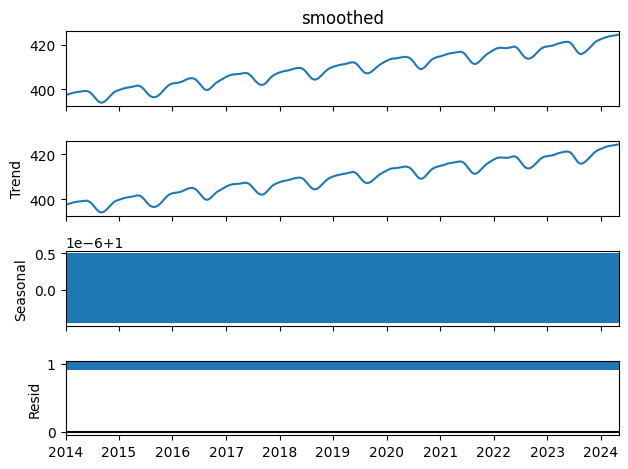

In [9]:
result = seasonal_decompose(df_daily['smoothed'], model='multiplicative')
result.plot()
plt.show()

# test for stationarity using dicky-fuller 

In [10]:
adf_result = adfuller(df['smoothed'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

if adf_result[1] > 0.05:
    print('Data is not stationary')
else:
    print('Data is stationary')

ADF Statistic: -1.2312888195730702
p-value: 0.6599933494169106
Data is not stationary


# test for stationarity using KPSS 

In [11]:
kpss_result = kpss(df['smoothed'], regression='c')
print(f'KPSS Statistic: {kpss_result[0]}')
print(f'p-value: {kpss_result[1]}')

if kpss_result[1] < 0.05:
    print('Data is not stationary')
else:
    print('Data is stationary')

KPSS Statistic: 9.082197856282606
p-value: 0.01
Data is not stationary


# Checking the order of difference

In [12]:
def adf_test(series):
    result = adfuller(series)
    return result[1]

In [13]:
d = 0
p_value = adf_test(df['smoothed'])

In [14]:
while p_value > 0.05:
    d += 1
    differenced_series = df['smoothed'].diff(d).dropna()
    p_value = adf_test(differenced_series)

In [15]:
print(f'The order of differencing required to make the time series stationary is: {d}')

The order of differencing required to make the time series stationary is: 1


In [16]:
differenced_series

date
2014-01-02    0.03
2014-01-03    0.02
2014-01-04    0.02
2014-01-05    0.02
2014-01-06    0.02
              ... 
2024-04-29    0.01
2024-04-30    0.00
2024-05-01    0.01
2024-05-02    0.00
2024-05-03    0.01
Name: smoothed, Length: 3775, dtype: float64

In [17]:
d = 1  
differenced_series = df['smoothed'].diff(d).dropna()

# Plot ACF of differenced series

<Figure size 1700x1000 with 0 Axes>

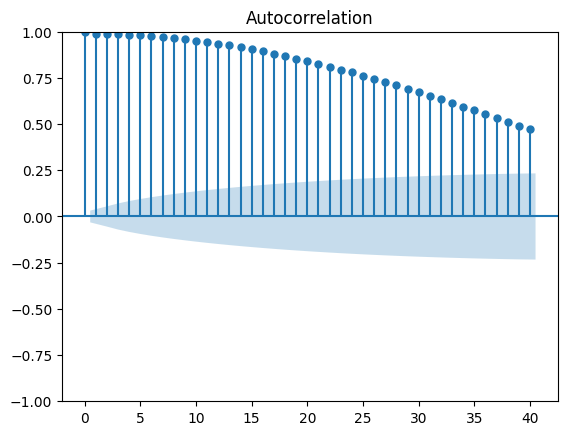

In [18]:
plt.figure(figsize=(17,10))
plot_acf(differenced_series, lags=40)
plt.show()

# Plot PACF of differenced series

<Figure size 1000x500 with 0 Axes>

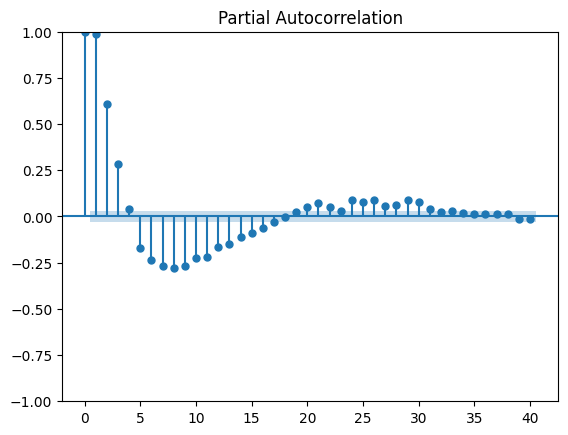

In [19]:
plt.figure(figsize=(10,5))
plot_pacf(differenced_series, lags=40)
plt.show()

# Using auto arima to get best order values

In [22]:
model = auto_arima(df['smoothed'], seasonal=True, stepwise=True, suppress_warnings=True, trace=True)
model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-29704.971, Time=4.58 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-13086.323, Time=0.25 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-26672.018, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-17031.467, Time=1.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-12984.488, Time=0.16 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-28940.709, Time=1.25 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-28540.976, Time=0.62 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-28188.509, Time=5.91 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-29101.726, Time=2.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-28215.846, Time=1.36 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-28686.085, Time=1.29 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-28732.469, Time=2.82 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=-30017.174, Time=4.94 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=-30244.749, Time=4.47 sec
 ARIM

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 3776
Model:               SARIMAX(4, 1, 4)   Log Likelihood               15152.616
Date:                Sat, 11 May 2024   AIC                         -30285.233
Time:                        23:33:08   BIC                         -30222.871
Sample:                             0   HQIC                        -30263.062
                               - 3776                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept  -3.999e-08    1.2e-05     -0.003      0.997   -2.36e-05    2.35e-05
ar.L1          0.3948      0.047      8.404      0.000       0.303       0.487
ar.L2          1.3932      0.065     21.549      0.000       1.267       1.520
ar.L3         -0.0108      0.049     -0.221      0.825      -0.107       0.085
ar.L4         -0.7775      0.039    -19.935      0.000      -0.854      -0.701
ma.L1         -0.3870      0.050     -7.677      0.000      -0.486      -0.288
ma.L2         -1.1520      0.067    -17.270      0.000      -1.283      -1.021
ma.L3          0.0600      0.057      1.046      0.295      -0.052       0.172
ma.L4          0.6442      0.042     15.168      0.000       0.561       0.727
sigma2      1.921e-05   3.59e-07     53.505      0.000    1.85e-05    1.99e-05
===================================================================================
Ljung-Box (L1) (Q):                 231.26   Jarque-Bera (JB):               292.89
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.99   Skew:                             0.15
Prob(H) (two-sided):                  0.88   Kurtosis:                         4.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# 1. Arima Model

# Train the model on train and test data

In [20]:
train = differenced_series[:-30]  
test = differenced_series[-30:]  

# Train and get summary 

In [34]:
model = ARIMA(train, order=(4, 1, 4))
model_fit = model.fit()
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               smoothed   No. Observations:                 3746
Model:                 ARIMA(4, 1, 4)   Log Likelihood               14222.960
Date:                Sun, 12 May 2024   AIC                         -28427.920
Time:                        20:50:51   BIC                         -28371.866
Sample:                             0   HQIC                        -28407.984
                               - 3746                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4737      0.063     -7.568      0.000      -0.596      -0.351
ar.L2          0.2795      0.049      5.723      0.000       0.184       0.375
ar.L3          0.6897      0.061     11.371      0.000       0.571       0.809
ar.L4          0.4778      0.040     11.881      0.000       0.399       0.557
ma.L1          0.7067      0.061     11.531      0.000       0.587       0.827
ma.L2          0.3936      0.051      7.653      0.000       0.293       0.494
ma.L3          0.0384      0.040      0.963      0.336      -0.040       0.117
ma.L4         -0.0383      0.037     -1.039      0.299      -0.111       0.034
sigma2      2.937e-05   6.54e-07     44.939      0.000    2.81e-05    3.07e-05
===================================================================================
Ljung-Box (L1) (Q):                   3.74   Jarque-Bera (JB):                62.85
Prob(Q):                              0.05   Prob(JB):                         0.00
Heteroskedasticity (H):               1.02   Skew:                             0.07
Prob(H) (two-sided):                  0.77   Kurtosis:                         3.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Get the predictions 

In [35]:
predictions = model_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Evaluate our model 

In [36]:
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
r2 = r2_score(test, predictions)

In [37]:
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.052166282413780136
MSE: 0.0032469581882403043
RMSE: 0.05698208655569138


# Now check the predicted with the test values and check if they are similar 

In [38]:
predictions.index = test.index

for i in range(len(predictions)):
    print(f'predicted={predictions[i]}, expected={test[i]}')

predicted=424.0584507843956, expected=424.07
predicted=424.06895691802123, expected=424.08
predicted=424.0781173565748, expected=424.09
predicted=424.08732771160453, expected=424.1
predicted=424.09681048652925, expected=424.12
predicted=424.1062321287935, expected=424.13
predicted=424.1151502817473, expected=424.14
predicted=424.1245015753839, expected=424.16
predicted=424.13359497538426, expected=424.17
predicted=424.14255511704914, expected=424.18
predicted=424.1515644540611, expected=424.2
predicted=424.16054233111987, expected=424.21
predicted=424.16933371592944, expected=424.22
predicted=424.1781748949344, expected=424.23
predicted=424.1869421659519, expected=424.25
predicted=424.195614698938, expected=424.26
predicted=424.20425667668565, expected=424.27
predicted=424.21285946067775, expected=424.28
predicted=424.221371606908, expected=424.29
predicted=424.229849383169, expected=424.3
predicted=424.2382764684123, expected=424.31
predicted=424.24663671116315, expected=424.32
predic

# Plot the predicted with actual 

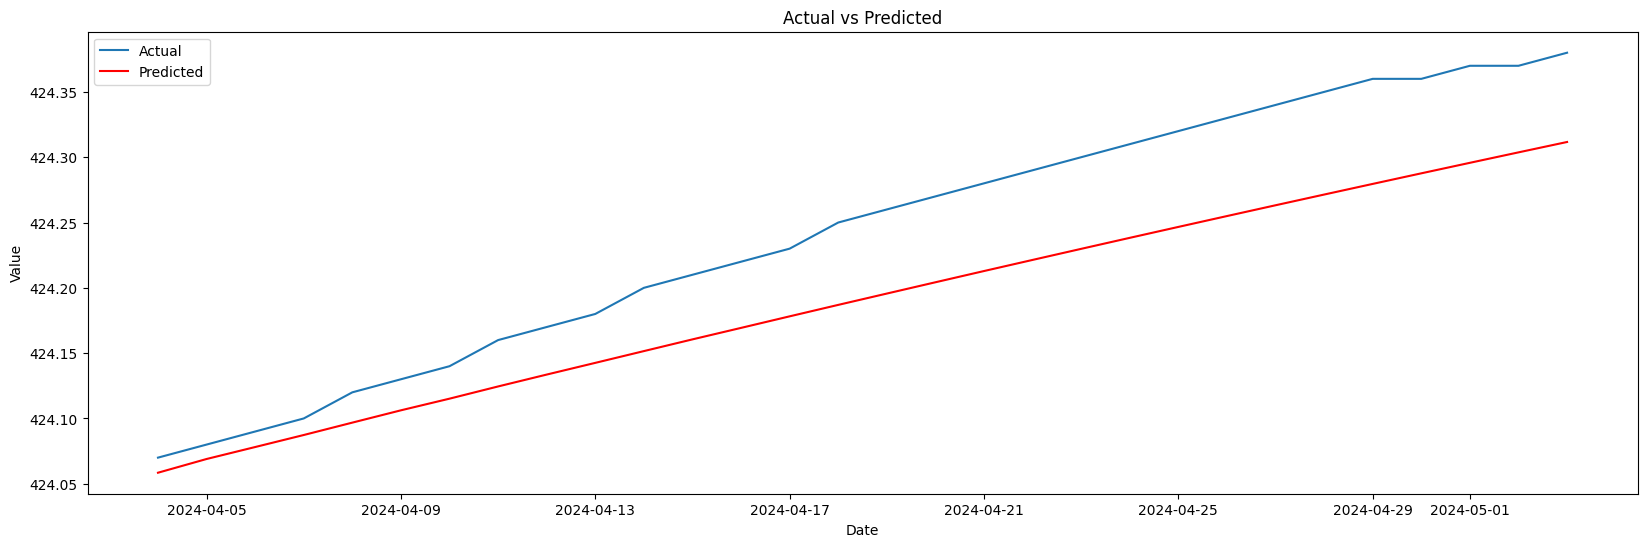

In [39]:
predictions.index = test.index

plt.figure(figsize=(20, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

In [40]:
test.mean()

424.2413333333334

In [41]:
rmse

0.05698208655569138

# Train new model with more data to test out

In [79]:
train = df['smoothed'][:-200]
test = df['smoothed'][-200:]

# Train second model 

In [80]:
model_2 = ARIMA(train, order=(4, 1, 4))
model_2_fit = model_2.fit()
model_2_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               smoothed   No. Observations:                 3576
Model:                 ARIMA(4, 1, 4)   Log Likelihood               13553.992
Date:                Sun, 12 May 2024   AIC                         -27089.983
Time:                        20:54:40   BIC                         -27034.348
Sample:                             0   HQIC                        -27070.149
                               - 3576                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4534      0.066     -6.843      0.000      -0.583      -0.324
ar.L2          0.2720      0.050      5.446      0.000       0.174       0.370
ar.L3          0.6708      0.062     10.772      0.000       0.549       0.793
ar.L4          0.4801      0.038     12.667      0.000       0.406       0.554
ma.L1          0.6321      0.065      9.738      0.000       0.505       0.759
ma.L2          0.3622      0.051      7.049      0.000       0.262       0.463
ma.L3          0.0414      0.042      0.980      0.327      -0.041       0.124
ma.L4         -0.0434      0.037     -1.158      0.247      -0.117       0.030
sigma2      2.974e-05   6.92e-07     42.980      0.000    2.84e-05    3.11e-05
===================================================================================
Ljung-Box (L1) (Q):                   3.64   Jarque-Bera (JB):                54.16
Prob(Q):                              0.06   Prob(JB):                         0.00
Heteroskedasticity (H):               1.09   Skew:                             0.05
Prob(H) (two-sided):                  0.13   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# Get predictions

In [81]:
predictions = model_2_fit.predict(start=len(train), end=len(train) + len(test) - 1)

# Check predictions

In [82]:
predictions.index = test.index

for i in range(len(predictions)):
    print(f'predicted={predictions[i]}, expected={test[i]}')

predicted=418.4785862035119, expected=418.48
predicted=418.54132230915474, expected=418.55
predicted=418.60493853180503, expected=418.62
predicted=418.66831580376896, expected=418.69
predicted=418.7318971363933, expected=418.76
predicted=418.79310280385596, expected=418.83
predicted=418.8557032329334, expected=418.9
predicted=418.9170473651632, expected=418.97
predicted=418.9778447535951, expected=419.04
predicted=419.0383434087382, expected=419.11
predicted=419.09865566372093, expected=419.18
predicted=419.15800128328124, expected=419.26
predicted=419.21727155690047, expected=419.33
predicted=419.2760446229909, expected=419.4
predicted=419.3342846939174, expected=419.47
predicted=419.39211655699916, expected=419.54
predicted=419.449618813905, expected=419.61
predicted=419.50656323397885, expected=419.68
predicted=419.563141191994, expected=419.75
predicted=419.61931648735003, expected=419.82
predicted=419.6750422196783, expected=419.89
predicted=419.7303486105294, expected=419.96
pred

# Plot predictions with actual

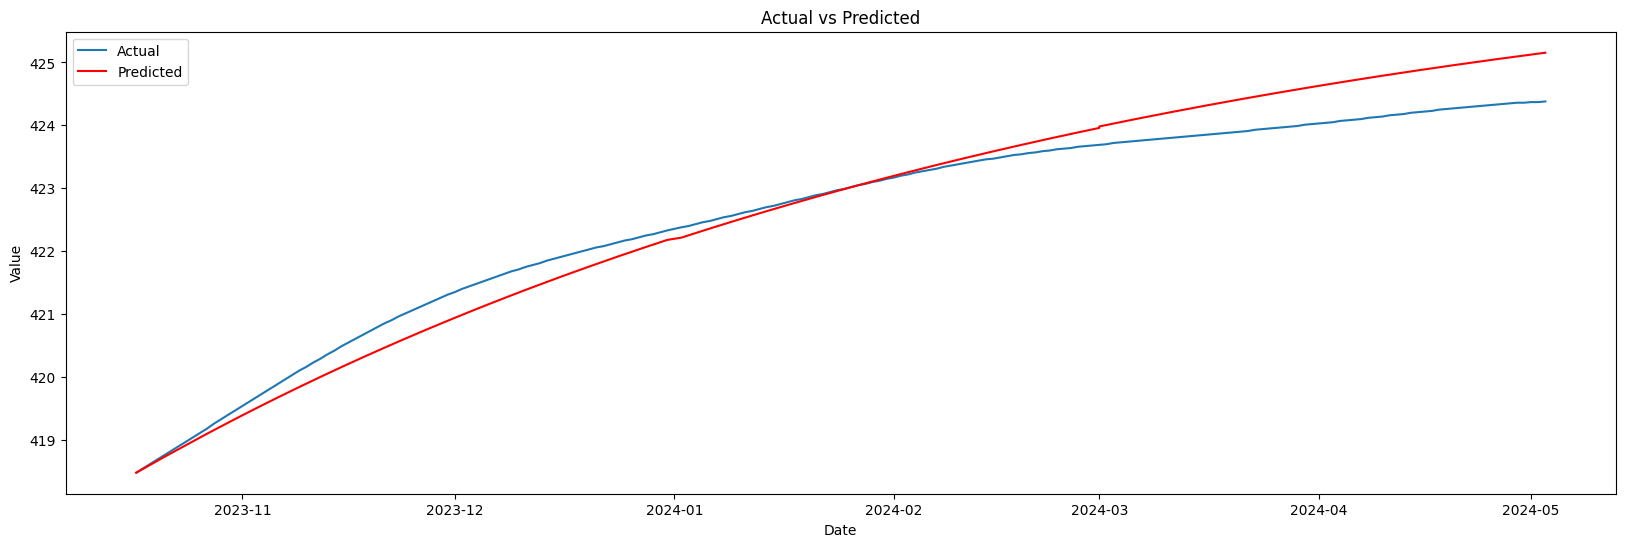

In [83]:
predictions.index = test.index

plt.figure(figsize=(20, 6))
plt.plot(test, label='Actual')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

# Evaluate second model

In [84]:
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
r2 = r2_score(test, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2}')

MAE: 0.30862947706607996
MSE: 0.14523400846315507
RMSE: 0.38109579958739387
R2 Score: 0.9441955785808541


# Select the best model by seeing r2 score and plot its forecast against actual df

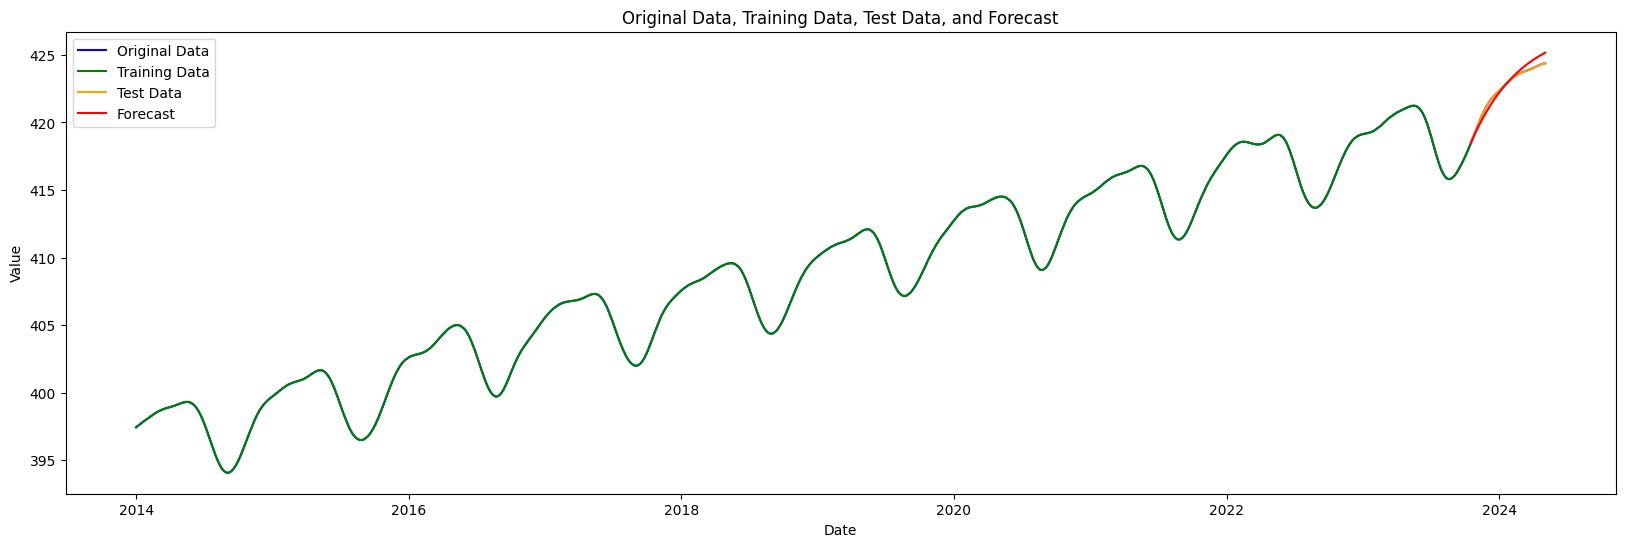

In [86]:
predictions.index = pd.date_range(start=test.index[0], periods=200, freq=test.index.freq)

plt.figure(figsize=(20, 6))
plt.plot(df['smoothed'], label='Original Data', color='blue')

# Plot training data
plt.plot(train.index, train.values, label='Training Data', color='green')

# Plot test data
plt.plot(test.index, test.values, label='Test Data', color='orange')

# Plot forecasted values
plt.plot(predictions.index, predictions.values, color='red', label='Forecast')

plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Original Data, Training Data, Test Data, and Forecast')
plt.legend()
plt.show()

# Save best model

In [87]:
with open('arima_model.pkl', 'wb') as f:
    pickle.dump(model_2_fit, f)

# Load Best Model

In [91]:
with open('arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)

In [92]:
predictions = arima_model.forecast(steps=30)
print("predictions:", predictions)

predictions: 3576    418.478586
3577    418.541322
3578    418.604939
3579    418.668316
3580    418.731897
3581    418.793103
3582    418.855703
3583    418.917047
3584    418.977845
3585    419.038343
3586    419.098656
3587    419.158001
3588    419.217272
3589    419.276045
3590    419.334285
3591    419.392117
3592    419.449619
3593    419.506563
3594    419.563141
3595    419.619316
3596    419.675042
3597    419.730349
3598    419.785277
3599    419.839768
3600    419.893857
3601    419.947554
3602    420.000844
3603    420.053733
3604    420.106238
3605    420.158346
Name: predicted_mean, dtype: float64


# Cross validation

In [37]:
# Define the number of folds for cross-validation
n_splits = 5

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Initialize lists to store evaluation metrics for each fold
mae_scores = []
mse_scores = []
rmse_scores = []
r2_scores = []

# Perform cross-validation
for train_index, test_index in tscv.split(df):
    train = df.iloc[train_index]['smoothed']
    test = df.iloc[test_index]['smoothed']
    
    # Fit ARIMA model
    arima_model = ARIMA(train, order=(1, 0, 3))  
    arima_model_fit = arima_model.fit()
    
    # Make predictions
    predictions = arima_model_fit.forecast(steps=len(test))
    
    # Calculate evaluation metrics
    mae = mean_absolute_error(test, predictions)
    mse = mean_squared_error(test, predictions)
    rmse = mse ** 0.5
    r2 = r2_score(test, predictions)
    
    # Append scores to lists
    mae_scores.append(mae)
    mse_scores.append(mse)
    rmse_scores.append(rmse)
    r2_scores.append(r2)

# Aggregate results
mean_mae = sum(mae_scores) / n_splits
mean_mse = sum(mse_scores) / n_splits
mean_rmse = sum(rmse_scores) / n_splits
mean_r2 = sum(r2_scores) / n_splits

print("Mean MAE:", mean_mae)
print("Mean MSE:", mean_mse)
print("Mean RMSE:", mean_rmse)
print("Mean R-squared:", mean_r2)

Mean MAE: 3.8407209115144325
Mean MSE: 22.566357117306772
Mean RMSE: 4.32652076735808
Mean R-squared: -2.291232117688515


# 2. SARIMA model

# Model fitting and training on dataset 

In [8]:
train = df['smoothed'][:-100]
test = df['smoothed'][-100:]

## using auto arima to get seasonal parameters

In [103]:
sarima_model = auto_arima(y=train, m=7)

In [104]:
predictions = pd.Series(sarima_model.predict(n_periods=len(test)))
predictions.index = test.index

for i in range(len(predictions)):
    print(f'predicted={predictions[i]}, expected={test[i]}')

predicted=423.0202386314462, expected=423.02
predicted=423.04694078912786, expected=423.05
predicted=423.0749105264371, expected=423.07
predicted=423.1031148437623, expected=423.1
predicted=423.13113723270726, expected=423.12
predicted=423.1597559540537, expected=423.15
predicted=423.18818676221395, expected=423.17
predicted=423.21703898989904, expected=423.2
predicted=423.24584112009586, expected=423.22
predicted=423.27490137979, expected=423.25
predicted=423.3039905288394, expected=423.27
predicted=423.3332390213488, expected=423.29
predicted=423.3625421922396, expected=423.31
predicted=423.3919468719996, expected=423.34
predicted=423.42140390430507, expected=423.36
predicted=423.4509246724461, expected=423.38
predicted=423.48048307245296, expected=423.4
predicted=423.51007641428447, expected=423.42
predicted=423.53968784960074, expected=423.44
predicted=423.5693094228182, expected=423.46
predicted=423.5989280058255, expected=423.47
predicted=423.62853384830674, expected=423.49
predi

<Axes: xlabel='date'>

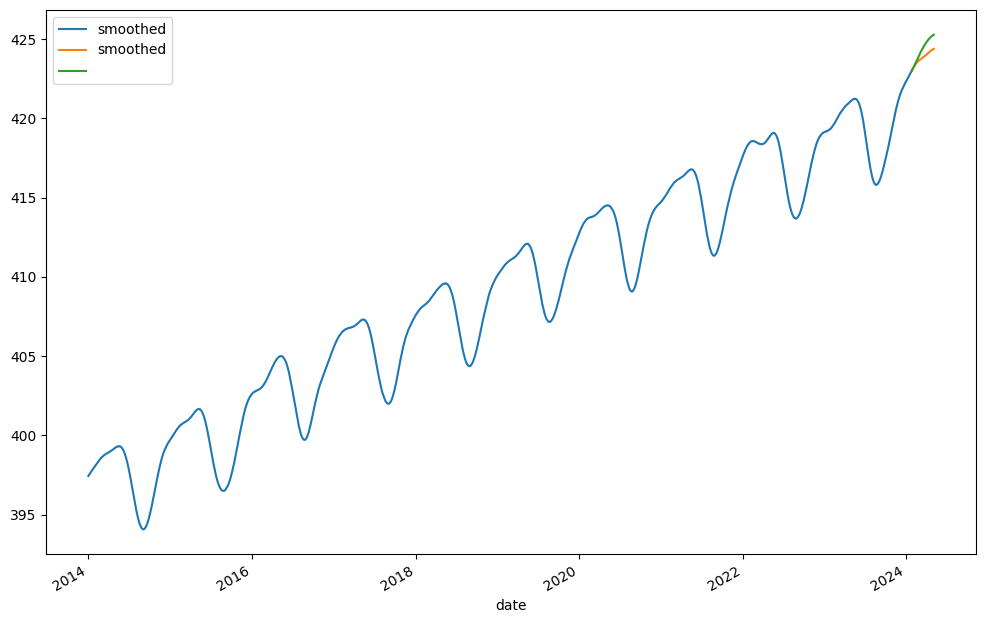

In [105]:
train.plot(figsize=(12, 8), legend=True)
test.plot(legend=True)
predictions.plot(legend=True)

In [106]:
mae = mean_absolute_error(test, predictions)
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
r2 = r2_score(test, predictions)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 0.5127543816928221
MSE: 0.3676817472416306
RMSE: 0.606367666718494


# Save Sarima model 

In [107]:
with open('sarima_model.pkl', 'wb') as f:
    pickle.dump(sarima_model, f)

# Load the model

In [6]:
with open('sarima_model.pkl', 'rb') as f:
    sarima_model = pickle.load(f)

In [11]:
# Number of future periods you want to forecast
n_periods_forecast = 200  # Example: forecast for the next 10 periods

# Predict the next n_periods_forecast values
forecast = pd.Series(sarima_model.predict(n_periods=n_periods_forecast))

# Generate a new index for the forecasted periods
last_index = test.index[-1]
forecast_index = pd.date_range(start=last_index, periods=n_periods_forecast)

# Set the index of the forecast series to the new forecast period index
forecast.index = forecast_index

# Print the forecasted values
for i in range(len(forecast)):
    print(f'forecasted={forecast[i]}, period={forecast.index[i]}')

forecasted=423.0202386314462, period=2024-05-03 00:00:00
forecasted=423.04694078912786, period=2024-05-04 00:00:00
forecasted=423.0749105264371, period=2024-05-05 00:00:00
forecasted=423.1031148437623, period=2024-05-06 00:00:00
forecasted=423.13113723270726, period=2024-05-07 00:00:00
forecasted=423.1597559540537, period=2024-05-08 00:00:00
forecasted=423.18818676221395, period=2024-05-09 00:00:00
forecasted=423.21703898989904, period=2024-05-10 00:00:00
forecasted=423.24584112009586, period=2024-05-11 00:00:00
forecasted=423.27490137979, period=2024-05-12 00:00:00
forecasted=423.3039905288394, period=2024-05-13 00:00:00
forecasted=423.3332390213488, period=2024-05-14 00:00:00
forecasted=423.3625421922396, period=2024-05-15 00:00:00
forecasted=423.3919468719996, period=2024-05-16 00:00:00
forecasted=423.42140390430507, period=2024-05-17 00:00:00
forecasted=423.4509246724461, period=2024-05-18 00:00:00
forecasted=423.48048307245296, period=2024-05-19 00:00:00
forecasted=423.51007641428

In [109]:
predictions = sarima_model.predict(n_periods=30)
print("predictions:", predictions)

predictions: 3676    423.020239
3677    423.046941
3678    423.074911
3679    423.103115
3680    423.131137
3681    423.159756
3682    423.188187
3683    423.217039
3684    423.245841
3685    423.274901
3686    423.303991
3687    423.333239
3688    423.362542
3689    423.391947
3690    423.421404
3691    423.450925
3692    423.480483
3693    423.510076
3694    423.539688
3695    423.569309
3696    423.598928
3697    423.628534
3698    423.658115
3699    423.687662
3700    423.717164
3701    423.746611
3702    423.775991
3703    423.805296
3704    423.834516
3705    423.863640
dtype: float64


# 3. Exponential Smoothing (ETS):

In [173]:
# Function to calculate Mean Absolute Percentage Error (MAPE)
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Function to plot actual vs. predicted values
def plot_forecast(actual, predicted, model_name):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label='Actual', color='blue')
    plt.plot(predicted, label='Predicted', color='red')
    plt.title(f'Actual vs Predicted ({model_name})')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [174]:
# Fit simple exponential smoothing model
ses_model = ExponentialSmoothing(df['smoothed'], trend=None, seasonal=None)
ses_result = ses_model.fit()

Simple Exponential Smoothing MSE: 0.001876642004329079
Simple Exponential Smoothing MAE: 0.03522775477046585
Simple Exponential Smoothing MAPE: 0.008622096021956143
Simple Exponential Smoothing R2 Score: 0.9999673635409292
Simple Exponential Smoothing Model Predictions: date
2014-01-01    397.44
2014-01-02    397.44
2014-01-03    397.47
2014-01-04    397.49
2014-01-05    397.51
               ...  
2024-04-29    424.35
2024-04-30    424.36
2024-05-01    424.36
2024-05-02    424.37
2024-05-03    424.37
Length: 3776, dtype: float64


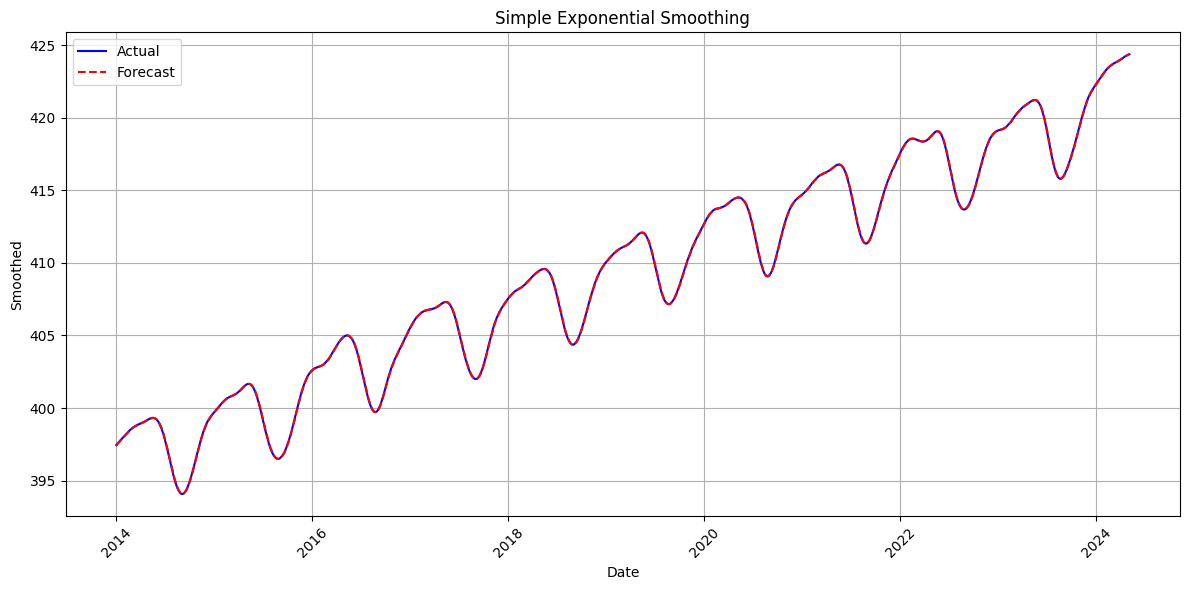

In [187]:
# Evaluate and plot simple exponential smoothing model
ses_predictions = ses_result.predict(start=df.index[0], end=df.index[-1])
ses_mse = mean_squared_error(df['smoothed'], ses_predictions)
ses_mae = mean_absolute_error(df['smoothed'], ses_predictions)
ses_mape = mean_absolute_percentage_error(df['smoothed'], ses_predictions)
ses_r2 = r2_score(df['smoothed'], ses_predictions)
print(f"Simple Exponential Smoothing MSE: {ses_mse}")
print(f"Simple Exponential Smoothing MAE: {ses_mae}")
print(f"Simple Exponential Smoothing MAPE: {ses_mape}")
print(f"Simple Exponential Smoothing R2 Score: {ses_r2}")
print(f"Simple Exponential Smoothing Model Predictions: {ses_predictions}")
plot_forecast(df['smoothed'], ses_predictions, 'Simple Exponential Smoothing')

# Get forecast for 50 days

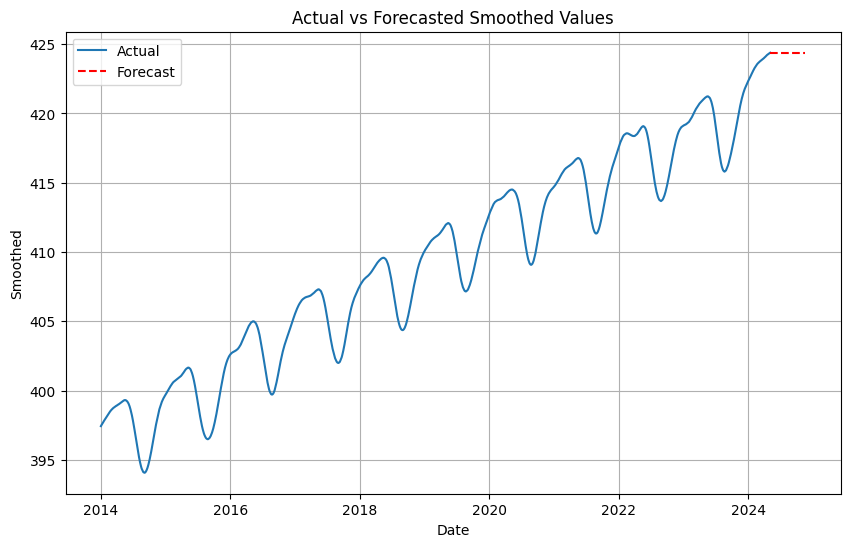

In [196]:
ses_forecast = ses_result.forecast(steps=200)
ses_forecast = pd.Series(ses_forecast)
ses_forecast.index = pd.date_range(start=df.index[-1], periods=200, freq=df.index.freq)

plt.figure(figsize=(10, 6))
plt.plot(df.index, df['smoothed'], label='Actual')
plt.plot(ses_forecast.index, ses_forecast, linestyle='--', color='red', label='Forecast')
plt.xlabel('Date')
plt.ylabel('Smoothed')
plt.title('Actual vs Forecasted Smoothed Values')
plt.legend()
plt.grid(True)
plt.show()

# Save any model

In [197]:
with open('ses_model.pkl', 'wb') as f:
    pickle.dump(ses_result, f)

# 4. Prophet

In [5]:
train = df['smoothed'][:-500]
test = df['smoothed'][-500:]

00:25:12 - cmdstanpy - INFO - Chain [1] start processing
00:25:14 - cmdstanpy - INFO - Chain [1] done processing


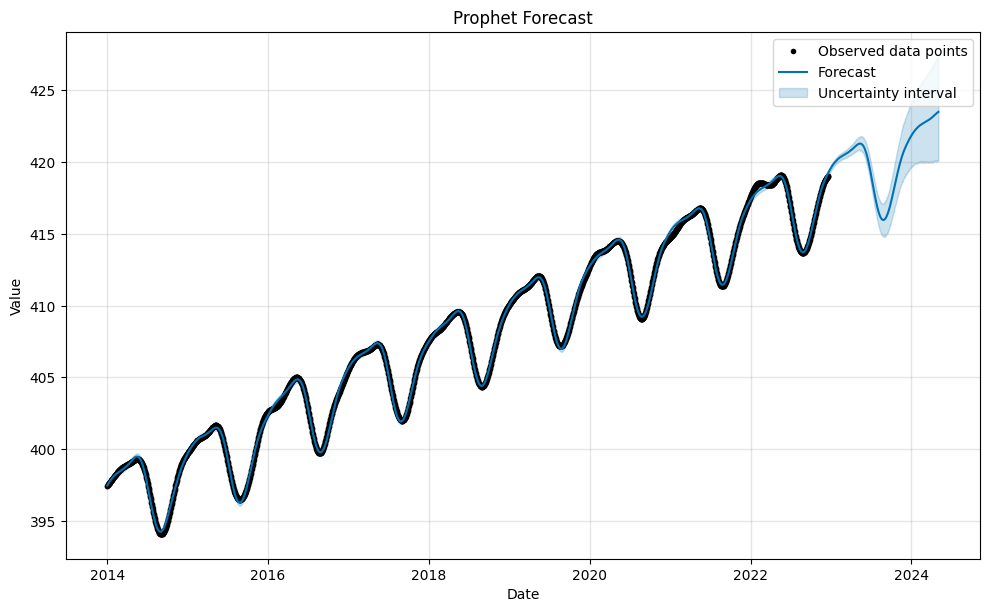

Prophet MSE: 0.2779697429292372
Prophet MAE: 0.4239527263864425
Prophet MAPE: 0.001005829419937758
Prophet R2 Score: 0.9526038629930078


In [6]:
# Prepare the training data
train_df = pd.DataFrame({'ds': train.index, 'y': train.values})

# Initialize and fit the Prophet model
prophet_model = Prophet()
prophet_model.fit(train_df)

# Make predictions for the testing data
future = prophet_model.make_future_dataframe(periods=len(test))
forecast = prophet_model.predict(future)

# Plot the forecast
prophet_model.plot(forecast)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prophet Forecast')
plt.legend()
plt.show()

# Evaluate the forecast
forecast_subset = forecast.set_index('ds').loc[test.index]
prophet_mse = mean_squared_error(test, forecast_subset['yhat'])
prophet_mae = mean_absolute_error(test, forecast_subset['yhat'])
prophet_mape = mean_absolute_percentage_error(test, forecast_subset['yhat'])
prophet_r2 = r2_score(test, forecast_subset['yhat'])
print(f"Prophet MSE: {prophet_mse}")
print(f"Prophet MAE: {prophet_mae}")
print(f"Prophet MAPE: {prophet_mape}")
print(f"Prophet R2 Score: {prophet_r2}")

# Check if overfitted

In [7]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform cross-validation
cv_results = cross_validation(prophet_model, initial='730 days', period='180 days', horizon='365 days')

# Calculate performance metrics
performance_metrics_results = performance_metrics(cv_results)
print(performance_metrics_results)

  0%|          | 0/13 [00:00<?, ?it/s]

00:25:19 - cmdstanpy - INFO - Chain [1] start processing
00:25:20 - cmdstanpy - INFO - Chain [1] done processing
00:25:20 - cmdstanpy - INFO - Chain [1] start processing
00:25:21 - cmdstanpy - INFO - Chain [1] done processing
00:25:22 - cmdstanpy - INFO - Chain [1] start processing
00:25:23 - cmdstanpy - INFO - Chain [1] done processing
00:25:23 - cmdstanpy - INFO - Chain [1] start processing
00:25:25 - cmdstanpy - INFO - Chain [1] done processing
00:25:26 - cmdstanpy - INFO - Chain [1] start processing
00:25:27 - cmdstanpy - INFO - Chain [1] done processing
00:25:27 - cmdstanpy - INFO - Chain [1] start processing
00:25:29 - cmdstanpy - INFO - Chain [1] done processing
00:25:29 - cmdstanpy - INFO - Chain [1] start processing
00:25:31 - cmdstanpy - INFO - Chain [1] done processing
00:25:32 - cmdstanpy - INFO - Chain [1] start processing
00:25:34 - cmdstanpy - INFO - Chain [1] done processing
00:25:34 - cmdstanpy - INFO - Chain [1] start processing
00:25:36 - cmdstanpy - INFO - Chain [1]

     horizon       mse      rmse       mae      mape     mdape     smape   
0    37 days  0.079398  0.281776  0.201169  0.000490  0.000329  0.000490  \
1    38 days  0.083650  0.289223  0.207241  0.000505  0.000342  0.000505   
2    39 days  0.088153  0.296906  0.213525  0.000520  0.000353  0.000521   
3    40 days  0.092846  0.304706  0.220003  0.000536  0.000370  0.000537   
4    41 days  0.097764  0.312673  0.226456  0.000552  0.000379  0.000552   
..       ...       ...       ...       ...       ...       ...       ...   
324 361 days  0.783911  0.885388  0.577686  0.001413  0.000621  0.001413   
325 362 days  0.789555  0.888569  0.580903  0.001421  0.000622  0.001421   
326 363 days  0.795492  0.891904  0.584185  0.001429  0.000624  0.001429   
327 364 days  0.801637  0.895342  0.587505  0.001437  0.000625  0.001438   
328 365 days  0.808160  0.898977  0.590968  0.001446  0.000628  0.001446   

     coverage  
0    0.478903  
1    0.475008  
2    0.470789  
3    0.467218  
4    0.

## Not overfitted as values are not getting more than 1 everytime 

In [8]:
count_less_than_one = performance_metrics_results[performance_metrics_results.coverage < 1].shape[0]

# Count occurrences of predicted values > 1
count_greater_than_one = performance_metrics_results[performance_metrics_results.coverage > 1].shape[0]

# Print the counts
print("Occurrences of predicted values < 1:", count_less_than_one)
print("Occurrences of predicted values > 1:", count_greater_than_one)

Occurrences of predicted values < 1: 110
Occurrences of predicted values > 1: 0


In [9]:
performance_metrics_results

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,0.079398,0.281776,0.201169,0.000490,0.000329,0.000490,0.478903
1,38 days,0.083650,0.289223,0.207241,0.000505,0.000342,0.000505,0.475008
2,39 days,0.088153,0.296906,0.213525,0.000520,0.000353,0.000521,0.470789
3,40 days,0.092846,0.304706,0.220003,0.000536,0.000370,0.000537,0.467218
4,41 days,0.097764,0.312673,0.226456,0.000552,0.000379,0.000552,0.464297
...,...,...,...,...,...,...,...,...
324,361 days,0.783911,0.885388,0.577686,0.001413,0.000621,0.001413,1.000000
325,362 days,0.789555,0.888569,0.580903,0.001421,0.000622,0.001421,1.000000
326,363 days,0.795492,0.891904,0.584185,0.001429,0.000624,0.001429,1.000000
327,364 days,0.801637,0.895342,0.587505,0.001437,0.000625,0.001438,1.000000


# Save model 

In [11]:
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(prophet_model, f)

In [12]:
with open('prophet_model.pkl', 'rb') as f:
    prophet = pickle.load(f)

# 5. SVR

In [29]:
X = df.drop(columns=['smoothed'])  # Features
y = df['smoothed']  # Target variable

In [30]:
# Step 2: Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
y_test.index

DatetimeIndex(['2023-08-31', '2016-09-26', '2022-04-11', '2018-03-31',
               '2020-08-25', '2024-03-20', '2022-02-03', '2023-12-25',
               '2015-04-11', '2017-01-28',
               ...
               '2021-04-19', '2022-11-27', '2017-11-25', '2021-06-08',
               '2014-04-19', '2018-08-03', '2016-02-05', '2020-03-29',
               '2022-09-16', '2023-09-15'],
              dtype='datetime64[ns]', name='date', length=756, freq=None)

In [210]:
# Step 3: Normalization/Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [211]:
# Step 4: Model Training
svr_model = SVR(kernel = 'rbf') 
svr_model.fit(X_train_scaled, y_train)

SVR()

In [212]:
# Step 5: Model Evaluation
y_pred = svr_model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 0.7421584089178259


In [213]:
# Step 6: Prediction on Test Data
predictions_test = svr_model.predict(X_test_scaled)

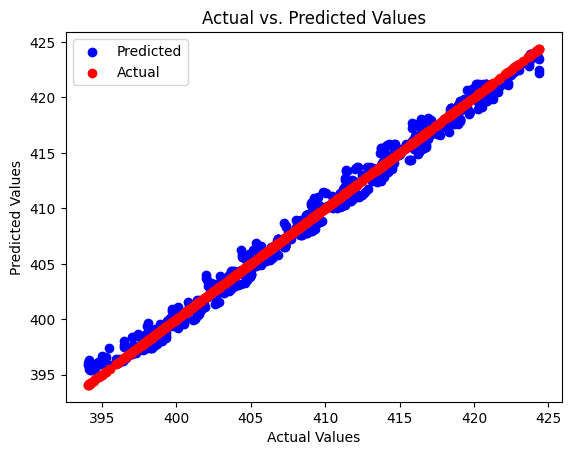

In [215]:
# Plot actual vs. predicted values with different colors
plt.scatter(y_test, y_pred, color='blue', label='Predicted')
plt.scatter(y_test, y_test, color='red', label='Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.legend()
plt.show()

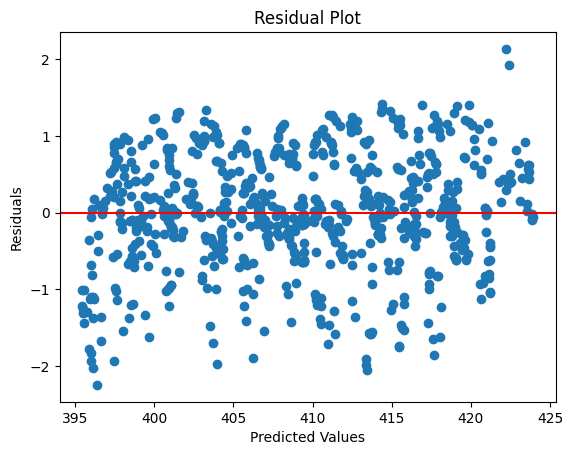

In [216]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals)
plt.axhline(y = 0, color='r', linestyle='-')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

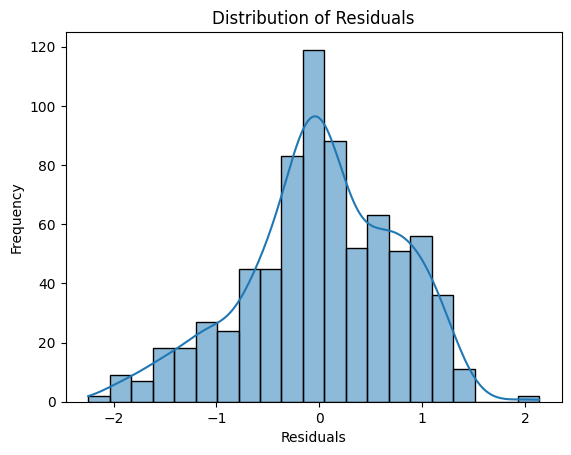

In [217]:
import seaborn as sns

sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals')
plt.show()

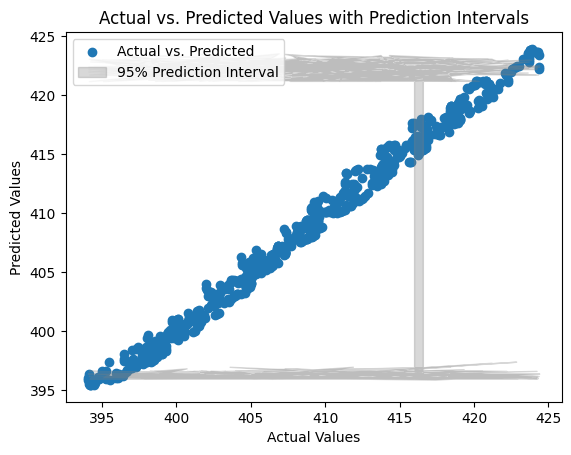

In [218]:
# Generate multiple predictions by bootstrapping
n_bootstraps = 1000
predictions_bootstrapped = []
for _ in range(n_bootstraps):
    indices = np.random.choice(len(y_pred), size=len(y_pred), replace=True)
    y_pred_bootstrap = y_pred[indices]
    predictions_bootstrapped.append(y_pred_bootstrap)

# Calculate percentiles for prediction intervals
prediction_intervals = np.percentile(predictions_bootstrapped, [2.5, 97.5], axis=0)

# Plot the actual vs. predicted values with prediction intervals
plt.scatter(y_test, y_pred, label='Actual vs. Predicted')
plt.fill_between(y_test, prediction_intervals[0], prediction_intervals[1], color='gray', alpha=0.3, label='95% Prediction Interval')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values with Prediction Intervals')
plt.legend()
plt.show()

In [220]:
# Calculate R-squared (R2) score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)

R-squared (R2) Score: 0.9908025849759614


# save model

In [219]:
with open('svr_model.pkl', 'wb') as f:
    pickle.dump(svr_model, f)

# 6. LSTM 

In [6]:
df.head()

,year,month,day,smoothed,trend
date,,,,,
2014-01-01,2014,1,1,397.44,396.34
2014-01-02,2014,1,2,397.47,396.35
2014-01-03,2014,1,3,397.49,396.35
2014-01-04,2014,1,4,397.51,396.36
2014-01-05,2014,1,5,397.53,396.37


In [7]:
train_size = int(len(df) * 0.8)  # 80% for training, 20% for testing
train, test = df.iloc[:train_size], df.iloc[train_size:]

In [8]:
scaler = MinMaxScaler()

In [9]:
df.head(), df.tail()

(            year  month  day  smoothed   trend
 date                                          
 2014-01-01  2014      1    1    397.44  396.34
 2014-01-02  2014      1    2    397.47  396.35
 2014-01-03  2014      1    3    397.49  396.35
 2014-01-04  2014      1    4    397.51  396.36
 2014-01-05  2014      1    5    397.53  396.37,
             year  month  day  smoothed   trend
 date                                          
 2024-04-29  2024      4   29    424.36  422.11
 2024-04-30  2024      4   30    424.36  422.11
 2024-05-01  2024      5    1    424.37  422.12
 2024-05-02  2024      5    2    424.37  422.13
 2024-05-03  2024      5    3    424.38  422.14)

In [10]:
scaled_train = scaler.fit_transform(train[['smoothed']])
scaled_test = scaler.transform(test[['smoothed']])

In [11]:
scaled_train[:10]

array([[0.13719886],
       [0.13842385],
       [0.13924051],
       [0.14005717],
       [0.14087383],
       [0.14169049],
       [0.14291548],
       [0.14373214],
       [0.1445488 ],
       [0.14536546]])

# Shaping data for neaural network 

## shaping data for batches of 20 days

In [12]:
n_input = 20

# Create generator which is making batches of 20 inputs and predicting 21st output

In [13]:
n_features = 1
train_generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
test_generator = TimeseriesGenerator(scaled_test, scaled_test, length=n_input, batch_size=1)

In [14]:
X, y = train_generator[0]
print(f'Given Array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')

Given Array: 
 [0.13719886 0.13842385 0.13924051 0.14005717 0.14087383 0.14169049
 0.14291548 0.14373214 0.1445488  0.14536546 0.14618212 0.14699878
 0.14781543 0.14863209 0.14944875 0.15067374 0.1514904  0.15230706
 0.15312372 0.15394038]
Predict this y: 
 [[0.15475704]]


In [15]:
X.shape

(1, 20, 1)

# Start the model building and training

### LSTM with 100 hundred neurons and activation function as relu, one output layer and adam optimizer 

In [16]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        40,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,901 (159.77 KB)

 Trainable params: 40,901 (159.77 KB)

 Non-trainable params: 0 (0.00 B)

# Model fit with generator which has inputs and outputs

In [18]:
model.fit(train_generator, epochs=6, verbose=1)

Epoch 1/6
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - loss: 0.0042
Epoch 2/6
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 1.5110e-04
Epoch 3/6
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 4.9344e-05
Epoch 4/6
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - loss: 2.0659e-05
Epoch 5/6
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 2.0093e-05
Epoch 6/6
3000/3000 ━━━━━━━━━━━━━━━━━━━━ 13s 4ms/step - loss: 2.6073e-05


# check if epochs should be decreased

### As seeing results we need to stop at 6 epochs

### Don't run this cell

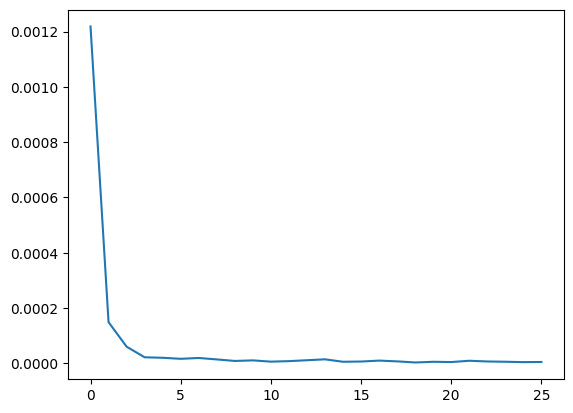

In [57]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

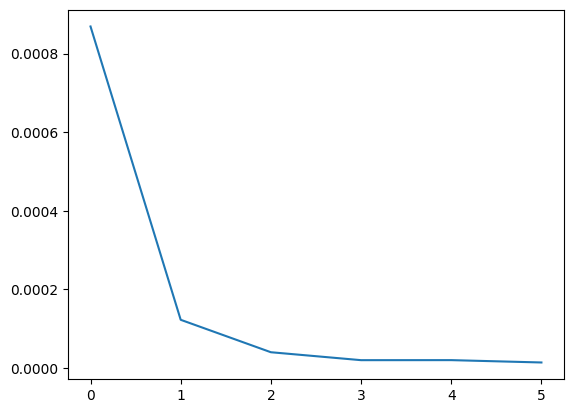

In [19]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)), loss_per_epoch)

# Using 20 last batch to get prediction of next day value

In [20]:
last_train_batch = scaled_train[-20:]

In [21]:
last_train_batch = last_train_batch.reshape((1, n_input, n_features))

# Get predictions on last batch so we get first element of test batch

In [22]:
model.predict(last_train_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step


array([[0.98555195]], dtype=float32)

# check if we are close to test value as here we are almost close 

In [23]:
scaled_test[0]

array([0.99510004])

# Now plot predictions 

736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


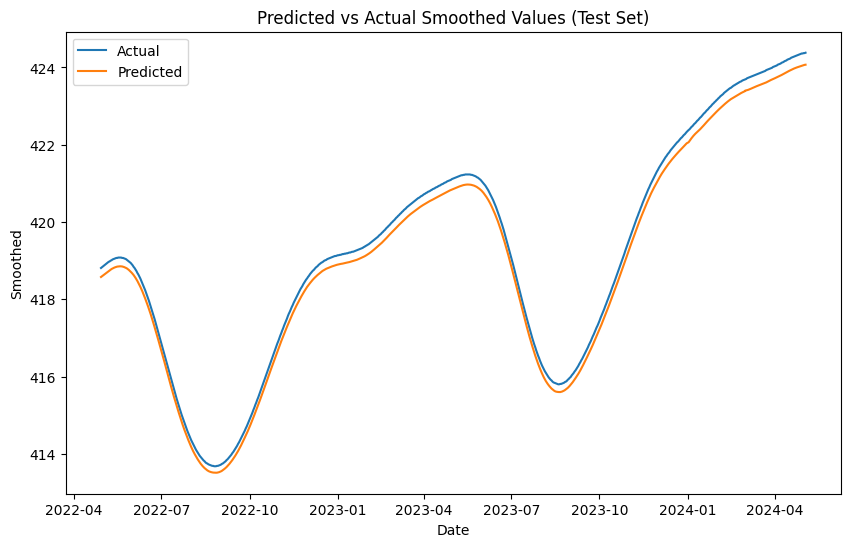

In [24]:
# Generate predictions for the test set
test_preds = model.predict(test_generator)

# Inverse transform the predictions
test_preds_inv = scaler.inverse_transform(test_preds)

# Plot the predictions against the actual values
plt.figure(figsize=(10, 6))
plt.plot(test.index[n_input:], test[['smoothed']].iloc[n_input:], label='Actual')
plt.plot(test.index[n_input:], test_preds_inv, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Smoothed')
plt.title('Predicted vs Actual Smoothed Values (Test Set)')
plt.legend()
plt.show()

# Forecasting about 20 days

In [25]:
# Define the number of future time steps to predict
future_steps = 20

In [26]:
# Generate the initial input sequence for prediction
initial_input = scaled_test[-n_input:].reshape((1, n_input, n_features))

In [27]:
# List to store the predicted values
future_preds = []

In [28]:
# Generate predictions for future time steps
for i in range(future_steps):
    future_pred = model.predict(initial_input)[0, 0]
    future_preds.append(future_pred)
    
    # Update the input sequence by removing the first value and appending the predicted value
    future_input = np.append(initial_input[:, 1:, :], [[[future_pred]]], axis=1)
    initial_input = future_input

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


# Plot future forecasting for 20 days

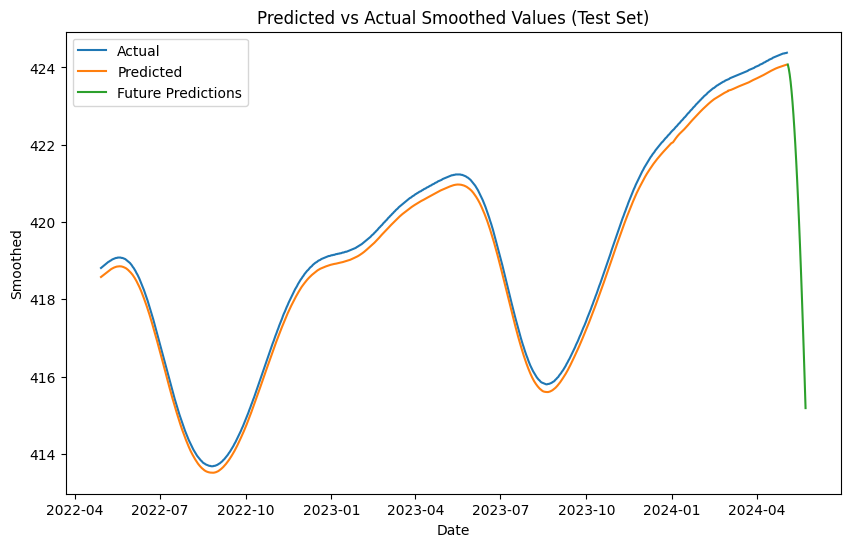

In [29]:
# Inverse transform the predicted values
future_preds_inv = scaler.inverse_transform(np.array(future_preds).reshape(-1, 1))

# Generate dates for the future predictions
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date, periods=future_steps + 1)[1:]

# Plot the actual values, predicted values, and future predictions
plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size + n_input:], df[['smoothed']].iloc[train_size + n_input:], label='Actual')
plt.plot(df.index[train_size + n_input:], test_preds_inv, label='Predicted')
plt.plot(future_dates, future_preds_inv, label='Future Predictions')
plt.xlabel('Date')
plt.ylabel('Smoothed')
plt.title('Predicted vs Actual Smoothed Values (Test Set)')
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import f1_score

# Get model predictions for the test set
test_preds = model.predict(test_generator)

# Inverse transform the predictions to original scale
test_preds_inv = scaler.inverse_transform(test_preds).flatten()
actual_values = test['smoothed'].values[n_input:]

# Define a threshold for binarizing predictions
threshold = 0.5 

# Convert predictions and actual values to binary classes based on the threshold
pred_classes = (test_preds_inv > threshold).astype(int)
actual_classes = (actual_values > threshold).astype(int)

# Compute the F1 score
f1 = f1_score(actual_classes, pred_classes)

print("F1 Score:", f1)

736/736 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
F1 Score: 1.0


# Save the LSTM model

In [32]:
model.save("lstm_model.keras")

# Load LSTM Model

In [34]:
lstm_model = load_model('lstm_model.keras')

# 7. ANN (Artificial Neural Network)

In [33]:
df.head()

,year,month,day,smoothed,trend
date,,,,,
2014-01-01,2014,1,1,397.44,396.34
2014-01-02,2014,1,2,397.47,396.35
2014-01-03,2014,1,3,397.49,396.35
2014-01-04,2014,1,4,397.51,396.36
2014-01-05,2014,1,5,397.53,396.37


# Preprocess the data 

In [34]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[['smoothed']])

# define number of stops to use as n_inputs

In [35]:
n_steps = 50

# Prepare data for ANN

In [36]:
X = []
y = []
for i in range(n_steps, len(scaled_data)):
    X.append(scaled_data[i - n_steps:i, 0])
    y.append(scaled_data[i, 0])
X, y = np.array(X), np.array(y)

# split data into training and testing dataset 80 20 

In [37]:
split = int(0.8 * len(X))
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

# Define the ANN

In [96]:
model = Sequential([
    Dense(100, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(50, activation='relu'),
    Dense(1)
])

# Compile model

In [97]:
model.compile(optimizer='adam', loss='mse')

# define early stopping to prevent overfitting

In [98]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model ANN

In [99]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0561 - val_loss: 2.4113e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.5279e-05 - val_loss: 1.5327e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.8415e-05 - val_loss: 2.9931e-05
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5242e-05 - val_loss: 8.2593e-05
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.2272e-05 - val_loss: 1.3626e-05
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.6280e-05 - val_loss: 3.1501e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.7727e-05 - val_loss: 1.0154e-05
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1.0232e-05 - val_loss: 9.0052e-06
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5.6921e-06 - val_loss: 1.7998e-05
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.3777e-06 - val_loss: 1.3266e-04


# Plot losses and valid losses 

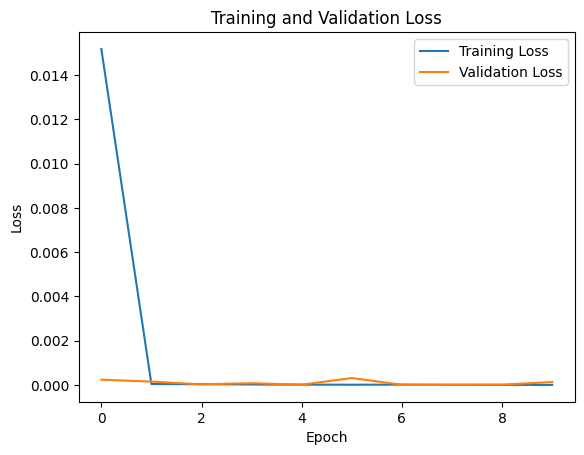

In [100]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Make predictions

In [101]:
predictions = model.predict(X_val)

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


# Inverse transform the predictions

In [102]:
predictions_inv = scaler.inverse_transform(predictions)

# Plot actual vs predicted values

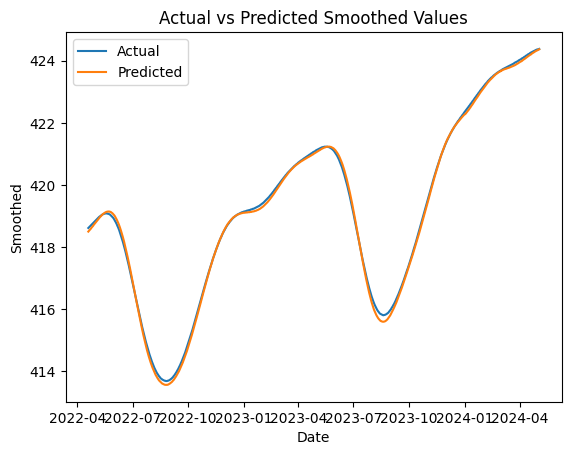

In [103]:
plt.plot(df.index[split + n_steps:], df['smoothed'][split + n_steps:], label='Actual')
plt.plot(df.index[split + n_steps:], predictions_inv, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Smoothed')
plt.title('Actual vs Predicted Smoothed Values')
plt.legend()
plt.show()

# Define a function to forecast future values

In [104]:
def forecast_future(model, initial_input, scaler, n_forecast_days):
    forecast = []

    # Initial input sequence
    current_input = initial_input.reshape(1, -1)  # Reshape for model prediction

    # Forecast for n_forecast_days
    for _ in range(n_forecast_days):
        # Predict the next day's value
        next_day_prediction = model.predict(current_input)
        
        # Inverse transform the prediction
        next_day_prediction_inv = scaler.inverse_transform(next_day_prediction)[0][0]
        
        # Append the prediction to the forecast
        forecast.append(next_day_prediction_inv)

        # Update the input sequence for the next prediction
        current_input = np.append(current_input[:, 1:], next_day_prediction).reshape(1, -1)

    return forecast

# Get the last n_steps data points as initial input for forecasting

In [105]:
initial_input = scaled_data[-n_steps:, 0]

# Forecast 150 days ahead

In [106]:
forecast = forecast_future(model, initial_input, scaler, 150)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

# Plot the forecasted values

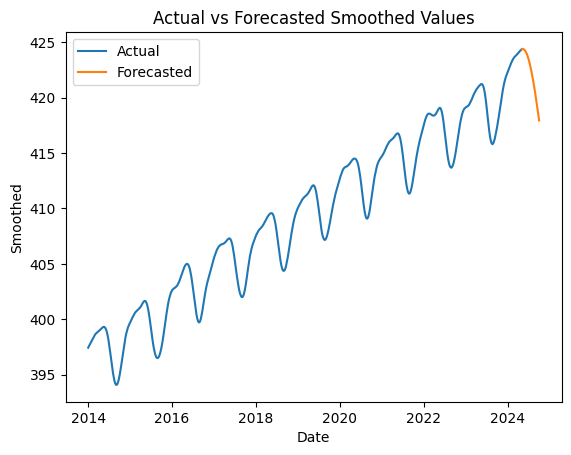

In [107]:
# Generate date range for forecasted values starting from the last date in df.index
forecast_dates = pd.date_range(start=df.index[-1], periods=150)

# Create a DataFrame for forecasted values with the same index as the actual data
forecast_df = pd.DataFrame(forecast, index=forecast_dates, columns=['Forecasted'])

# Concatenate actual and forecasted values along the index
combined_df = pd.concat([df['smoothed'], forecast_df])

# Plot actual and forecasted values
plt.plot(combined_df.index, combined_df[0], label='Actual')
plt.plot(forecast_df.index, forecast_df['Forecasted'], label='Forecasted')
plt.xlabel('Date')
plt.ylabel('Smoothed')
plt.title('Actual vs Forecasted Smoothed Values')
plt.legend()
plt.show()

# Get f1 score

In [108]:
from sklearn.metrics import f1_score

# Define a threshold
threshold = 0.5

# Convert actual values to binary labels based on the threshold
actual_labels = (df['smoothed'][split + n_steps:] > threshold).astype(int)

# Convert predicted values to binary labels based on the threshold
predicted_labels = (predictions_inv > threshold).astype(int)

# Compute F1 score
f1 = f1_score(actual_labels, predicted_labels)

print("F1 Score:", f1)

F1 Score: 1.0


# Save ANN model 

In [109]:
model.save('ANN_model.keras')

# 8. ANN + ARIMA (Hybrid Model)

# Load ANN Model and Arima Models

In [14]:
with open('arima_model.pkl', 'rb') as f:
    arima_model = pickle.load(f)

In [15]:
ANN_model = load_model('ANN_model.keras')

# Split data into train and test

In [16]:
train = df['smoothed'][:-200]
test = df['smoothed'][-200:]

# Get ARIMA predictions

In [17]:
arima_predictions = arima_model.predict(start=len(train), end=len(train) + len(test) - 1)
arima_predictions = arima_predictions.values.reshape(-1, 1)

# Calculate residuals

In [18]:
residuals = test.values - arima_predictions.flatten()

# Repeat ARIMA predictions for ANN input

In [19]:
n_features = ANN_model.input_shape[1]
repeated_predictions = np.repeat(arima_predictions, n_features, axis=1)

# Train ANN on residuals

In [20]:
ANN_model.fit(repeated_predictions, residuals, epochs=100, batch_size=32)

Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 81666.7656   
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3009.8174
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2278.2166 
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 460.1740 
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 214.6564
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 174.8770 
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56.9355 
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17.4287
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15.3097 
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9.3174  
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2.6562 
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9450 
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.8453 
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5594 
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2571 


# Predict residuals using ANN

In [21]:
hybrid_residuals = ANN_model.predict(repeated_predictions)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


# Add predicted residuals to ARIMA predictions to get hybrid predictions

In [22]:
hybrid_predictions = arima_predictions.flatten() + hybrid_residuals.flatten()

# Calculate evaluation metrics

In [23]:
hybrid_mae = mean_absolute_error(test, hybrid_predictions)
hybrid_mse = mean_squared_error(test, hybrid_predictions)
hybrid_rmse = np.sqrt(hybrid_mse)
hybrid_r2 = r2_score(test, hybrid_predictions)

print("Hybrid MAE:", hybrid_mae)
print("Hybrid MSE:", hybrid_mse)
print("Hybrid RMSE:", hybrid_rmse)
print("Hybrid R2 Score:", hybrid_r2)

Hybrid MAE: 0.3292926621206368
Hybrid MSE: 0.13853175260765846
Hybrid RMSE: 0.37219853923364404
Hybrid R2 Score: 0.9467708398035998


# Visualize actual vs. predicted values

In [26]:
hybrid_predictions_series = pd.Series(hybrid_predictions, index=test.index)

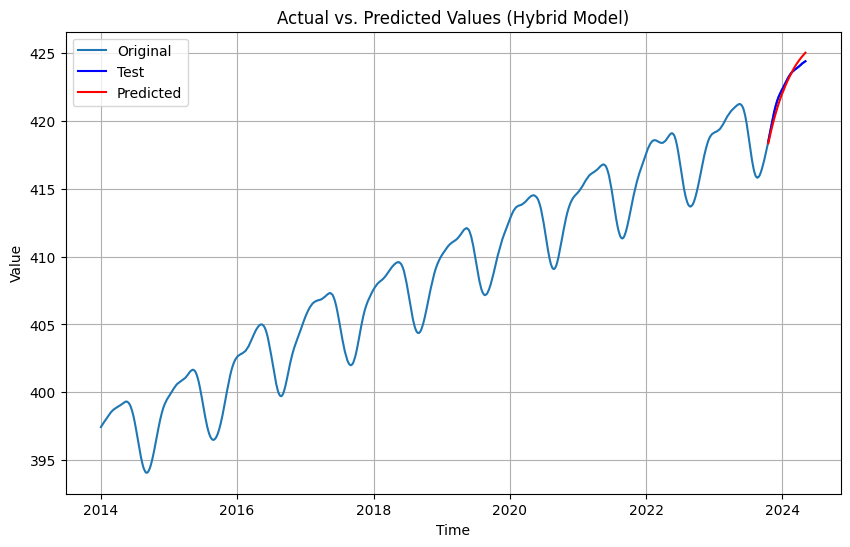

In [28]:
plt.figure(figsize=(10, 6))
plt.plot(df['smoothed'], label='Original')
plt.plot(test, label='Test', color='blue')
plt.plot(hybrid_predictions_series, label='Predicted', color='red')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual vs. Predicted Values (Hybrid Model)')
plt.legend()
plt.grid(True)
plt.show()

# Forecasting for 250 days

In [60]:
# Forecasting for the next 100 days using the hybrid model
forecast_start_date = test.index[-1] + pd.DateOffset(days=1)
forecast_end_date = forecast_start_date + pd.DateOffset(days=249)

# Predictions for the next 250 days
forecast_predictions = []

for i in range(250):
    # Predictions from ARIMA model
    arima_forecast = arima_model.predict(start=len(train) + len(test) + i, end=len(train) + len(test) + i).values
    repeated_forecast = np.repeat(arima_forecast.reshape(-1, 1), n_features, axis=1)
    
    # Predictions from hybrid model
    hybrid_forecast = ANN_model.predict(repeated_forecast)
    forecast_predictions.append(hybrid_forecast[0][0])

# Creating index for the forecast period
forecast_index = pd.date_range(start=forecast_start_date, end=forecast_end_date)

# Creating pandas Series for the forecast
forecast_series = pd.Series(forecast_predictions, index=forecast_index)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

# Plot actual with forecast

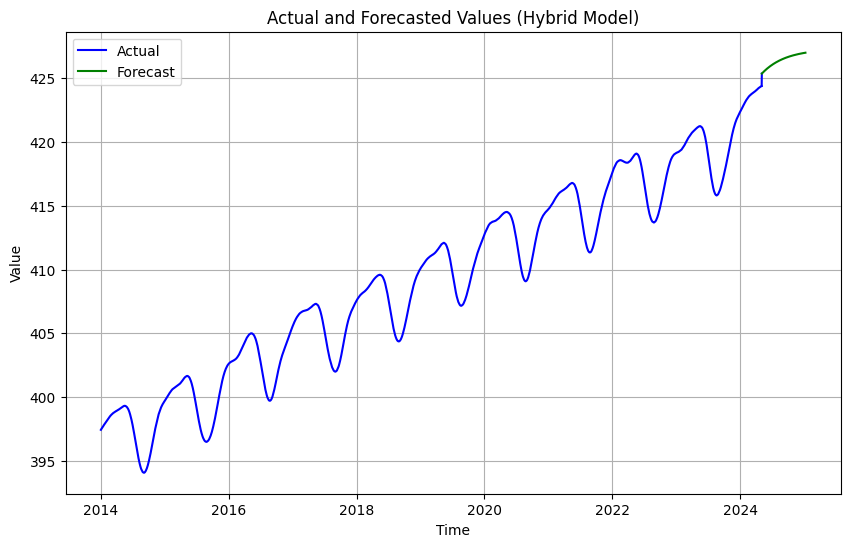

In [61]:
plt.figure(figsize=(10, 6))

# Plot actual data
plt.plot(df.index, df['smoothed'], label='Actual', color='blue')

# Plot forecast, connecting it with the actual data
plt.plot([df.index[-1], forecast_series.index[0]], [df['smoothed'].iloc[-1], forecast_series.iloc[0]], color='blue')
plt.plot(forecast_series.index, forecast_series, label='Forecast', color='green')

plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Actual and Forecasted Values (Hybrid Model)')
plt.legend()
plt.grid(True)
plt.show()

# Save the hybrid predictions

In [71]:
hybrid_predictions_series.to_csv('Hybrid_results.csv')